In [20]:

#Installing all necessary packages 
!pip install snowflake-connector-python[pandas]
!pip install holidays
!pip install --upgrade snowflake-sqlalchemy
!pip install imblearn
!pip install catboost
!pip install probatus
from probatus.feature_elimination import ShapRFECV
!pip install tensorflow
!pip install ipywidgets
!pip install pandas_profiling
!pip install optuna


import optuna
from sklearn.metrics import mean_squared_error
from pandas_profiling import ProfileReport
import snowflake.connector
import numpy as np
import pandas as pd
import datetime as dt
import boto3
import base64
from numpy import dtype, isnan, sqrt
from sqlalchemy import create_engine
from sqlalchemy import pool
from sqlalchemy.dialects import registry
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization
from botocore.exceptions import ClientError
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from dateutil.easter import *
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
import dask.dataframe as dd
import dask
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import catboost
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC


import seaborn as sns
import shap
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from optuna.samplers import TPESampler
import catboost
import pickle

!jupyter nbextension enable --py widgetsnbextension

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validati

In [21]:
# Connect to snowflake
ctx = snowflake.connector.connect(
      user='TWINKLE',
      account='mja29153.us-east-1',
      password = '@Luiwatson7',
      warehouse='PROGRESSIVE_LARGE',
      database='CLIENT',
      schema='PROGRESSIVE'
  )




In [22]:
cur = ctx.cursor()
sql = \
"""
 SELECT  c.*, s.*, d.CONVERSION_TYPE
 FROM CLIENT.PROGRESSIVE.IAS_IMPRESSIONS_LOGS c
 INNER JOIN CLIENT.PROGRESSIVE.REDS_IMPRESSIONS s
 ON SUBSTR(c.ext_imp_id_1, 5) = s.impression_id
 JOIN CLIENT.PROGRESSIVE.REDS_CONVERSIONS d
 ON s.tdid = d.tdid
 JOIN CLIENT.BOMBORA.ALL_ATTRIBUTES_FLAT m
 ON s.tdid = m.TDID
 WHERE s.TDID <> '00000000-0000-0000-0000-000000000000'
 ORDER BY s.DATE DESC
 **(last 2 weeks dates) 
 limit 1000000;

                  
"""
cur.execute(sql)

## Add limit 10 mil after date (before 'as a')
### Documentation 
# Fetch the result set from the cursor and deliver it as the Pandas DataFrame.


df = cur.fetch_pandas_all()

#for df in cur.fetch_pandas_all():df.to_pickle('df')



# # Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
# #for df in cur.fetch_pandas_batches():
#  #   my_dataframe_processing_function(df)
cur.close()
ctx.close()

In [23]:
df.to_pickle('df_uplift')

In [24]:
df = pd.read_pickle('df_uplift')
#df = df.sample(frac=0.3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539067 entries, 0 to 8056
Columns: 127 entries, TIME_RECEIVED to CONVERSION_TYPE
dtypes: datetime64[ns](4), float64(20), int16(2), int32(1), int64(1), int8(22), object(77)
memory usage: 439.0+ MB


In [25]:
df.head()


,TIME_RECEIVED,EXT_IMP_ID_1,BUNDLE_ID,IN_VIEW_FIELD,MEASURABLE,AD_SIZE,IN_VIEW_5S,IN_VIEW_15S,FULLY_IN_VIEW_1S,FULLY_IN_VIEW_5S,...,PARTNER_NAME,PRIVATE_CONTRACT_NAME,SUPPLY_VENDOR_NAME,TTD_NATIVE_CONTEXT_TYPE_NAME,WEEK_OF_YEAR,TIME_OF_WEEK_NAME,METRO_NAME,GEO_SEGMENT_ID,GEO_SEGMENT_NAME,CONVERSION_TYPE
0,1668999750977,v4~~b764ae83-f6f8-4221-b934-c8cec8f3e832,null,N/A,0,0x0,-1,-1,-1,-1,...,Progressive Insurance,None,None,None,47,Sunday: 19:00,Eugene OR,1z9z28lukn,United States - DMA - Eugene OR,other:p9m14l1
1,1668999743811,v4~~07879ef9-0b4d-4ee2-b073-e5176754e28d,null,N/A,0,0x0,-1,-1,-1,-1,...,Progressive Insurance,None,None,None,47,Sunday: 19:00,Eugene OR,1z9z28lukn,United States - DMA - Eugene OR,other:p9m14l1
2,1669011910708,v4~~d3b379d7-e601-4b52-8ee7-8beccceda33d,null,inView,1,0x0,1,1,1,1,...,Progressive Insurance,None,None,None,47,Monday: 1:00,None,None,None,other:x8cxk4v
3,1669007614943,v4~~57c80fa1-bd3b-4385-a47f-57d1adc3ae3d,null,N/A,1,0x0,-1,-1,-1,-1,...,Progressive Insurance,None,None,None,47,Sunday: 21:00,Las Vegas NV,hc97p4ch5u,United States - DMA - Las Vegas NV,other:x8cxk4v
4,1668992644408,v4~~760c533b-3e85-4af3-9d24-173338e004c2,null,inView,1,298x168,1,0,1,1,...,Progressive Insurance,None,None,None,47,Sunday: 19:00,Dallas-Ft. Worth TX,y2muwi8xz9,United States - DMA - Dallas-Ft. Worth TX,other:x8cxk4v


In [26]:
df.CONVERSION_TYPE.value_counts()

other:x8cxk4v    359547
other:p9m14l1    114454
other:5yo106e     17601
other:kz7kzx1     17601
other:57prdip      9071
other:bpafksy      5348
other:7rmxthn      3211
other:jql5bv2      2960
other:1rtxdex      2831
other:qhl1wil      1616
other:5yjxvn6      1392
other:nm61ffa      1389
other:6yyj35u       929
other:hlj0bka       280
other:pykk8cd       210
other:keld5dk       198
other:jjbey7r       147
other:63c7j6q       147
other:hv83pe5        71
other:kof941w        44
other:j6bm5uv        19
other:8sxvwi5         1
Name: CONVERSION_TYPE, dtype: int64

In [27]:
df_video =df[df["AD_GROUP_NAME"].isin(['Chalice LTV Video - 2022', 'Chalice LTV Video - 2022 - PSA'])] 


In [28]:
df_video['y'] = np.where(df_video['AD_GROUP_NAME'] == 'Chalice LTV Video - 2022', 1 ,0)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
df_video['treat'] = np.where(df_video['CONVERSION_TYPE'] == 'other:x8cxk4v', 1 ,0)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
df_video.treat.value_counts()

1    156040
0     77681
Name: treat, dtype: int64

In [32]:
df_video.y.value_counts()

1    198203
0     35518
Name: y, dtype: int64

In [33]:
df_video = df_video[['BROWSER_NAME', 'SUPPLY_VENDOR', 'DEVICE_MAKE', 'DEVICE_MODEL', 
            'DEVICE_NAME', 'RENDERING_CONTEXT', 'REGION', 'METRO', 'ZIP_POSTAL_CODE',
            'SITE', 'OS_FAMILY_NAME', 'AD_FORMAT',
            'MATCHED_FOLD_POSITION', 'USER_HOUR_OF_WEEK','y', 'IN_VIEW_FIELD', 'MEASURABLE', 'AD_SIZE', 'IN_VIEW_5S', 
            'IN_VIEW_15S', 'FULLY_IN_VIEW_1S', 'FULLY_IN_VIEW_5S', 'VIDEO_AD_1Q_IN_VIEW', 'VIDEO_AD_2Q_IN_VIEW',
            'VIDEO_AD_3Q_IN_VIEW', 'VIDEO_AD_4Q_IN_VIEW', 'DOWNLOAD_SCORE', 'INVALID_TRAFFIC_TYPE', "FREQUENCY", "TDID", 'treat']]
df_video.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233721 entries, 0 to 8053
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   BROWSER_NAME           233676 non-null  object
 1   SUPPLY_VENDOR          233721 non-null  object
 2   DEVICE_MAKE            228821 non-null  object
 3   DEVICE_MODEL           233640 non-null  object
 4   DEVICE_NAME            233721 non-null  object
 5   RENDERING_CONTEXT      233721 non-null  object
 6   REGION                 232603 non-null  object
 7   METRO                  224817 non-null  object
 8   ZIP_POSTAL_CODE        226154 non-null  object
 9   SITE                   233721 non-null  object
 10  OS_FAMILY_NAME         233676 non-null  object
 11  AD_FORMAT              233721 non-null  object
 12  MATCHED_FOLD_POSITION  233721 non-null  object
 13  USER_HOUR_OF_WEEK      233721 non-null  int16 
 14  y                      233721 non-null  int64 
 15  IN

In [34]:
df_video= df_video.dropna()
df_video


,BROWSER_NAME,SUPPLY_VENDOR,DEVICE_MAKE,DEVICE_MODEL,DEVICE_NAME,RENDERING_CONTEXT,REGION,METRO,ZIP_POSTAL_CODE,SITE,...,FULLY_IN_VIEW_5S,VIDEO_AD_1Q_IN_VIEW,VIDEO_AD_2Q_IN_VIEW,VIDEO_AD_3Q_IN_VIEW,VIDEO_AD_4Q_IN_VIEW,DOWNLOAD_SCORE,INVALID_TRAFFIC_TYPE,FREQUENCY,TDID,treat
0,Chrome,connatix,Motorola,Moto E (2020),Mobile,Other,Oregon,801,97478,www.kezi.com,...,-1,-1,-1,-1,-1,1000,0,0,0d53327b-2c73-4de5-b94f-8c2b5ee7322b,0
1,Chrome,connatix,Motorola,Moto E (2020),Mobile,Other,Oregon,801,97478,www.kezi.com,...,-1,-1,-1,-1,-1,1000,0,0,0d53327b-2c73-4de5-b94f-8c2b5ee7322b,0
4,Chrome,triplelift,Google,Chrome - Windows,PC,Other,Texas,623,75042,www.chegg.com,...,1,1,0,0,0,1000,0,0,7ccf9d60-fe34-4db9-8573-499a0405204d,1
5,Chrome,Magnite DV+,OnePlus,LE2125,Mobile,Other,North Carolina,560,27610,rankedboost.com,...,1,1,1,1,1,1000,0,0,14e230ca-8141-461b-8375-74b69edf3d61,1
6,Safari,sonobi,Apple,iPhone,Mobile,Other,South Dakota,764,57701,slatereport.com,...,0,1,1,1,1,1000,0,0,f9900c5b-abc6-4a89-b531-c5eef213ab10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8047,Chrome,pubmatic,Motorola,XT2093DL,Mobile,MobileOptimizedWeb,Pennsylvania,504,19146,looacademy.com,...,1,1,1,1,1,1000,0,0,b39abf1a-e79c-4869-bf0f-74b26ab01505,1
8048,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,0,1,0,0,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1
8049,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,0,1,0,0,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1
8050,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,1,1,1,1,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1


In [35]:
df_video['Counts'] = df_video.groupby(['y', "TDID"])['TDID'].transform('count')

df_video

,BROWSER_NAME,SUPPLY_VENDOR,DEVICE_MAKE,DEVICE_MODEL,DEVICE_NAME,RENDERING_CONTEXT,REGION,METRO,ZIP_POSTAL_CODE,SITE,...,VIDEO_AD_1Q_IN_VIEW,VIDEO_AD_2Q_IN_VIEW,VIDEO_AD_3Q_IN_VIEW,VIDEO_AD_4Q_IN_VIEW,DOWNLOAD_SCORE,INVALID_TRAFFIC_TYPE,FREQUENCY,TDID,treat,Counts
0,Chrome,connatix,Motorola,Moto E (2020),Mobile,Other,Oregon,801,97478,www.kezi.com,...,-1,-1,-1,-1,1000,0,0,0d53327b-2c73-4de5-b94f-8c2b5ee7322b,0,24
1,Chrome,connatix,Motorola,Moto E (2020),Mobile,Other,Oregon,801,97478,www.kezi.com,...,-1,-1,-1,-1,1000,0,0,0d53327b-2c73-4de5-b94f-8c2b5ee7322b,0,24
4,Chrome,triplelift,Google,Chrome - Windows,PC,Other,Texas,623,75042,www.chegg.com,...,1,0,0,0,1000,0,0,7ccf9d60-fe34-4db9-8573-499a0405204d,1,26
5,Chrome,Magnite DV+,OnePlus,LE2125,Mobile,Other,North Carolina,560,27610,rankedboost.com,...,1,1,1,1,1000,0,0,14e230ca-8141-461b-8375-74b69edf3d61,1,24
6,Safari,sonobi,Apple,iPhone,Mobile,Other,South Dakota,764,57701,slatereport.com,...,1,1,1,1,1000,0,0,f9900c5b-abc6-4a89-b531-c5eef213ab10,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8047,Chrome,pubmatic,Motorola,XT2093DL,Mobile,MobileOptimizedWeb,Pennsylvania,504,19146,looacademy.com,...,1,1,1,1,1000,0,0,b39abf1a-e79c-4869-bf0f-74b26ab01505,1,38
8048,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,1,0,0,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1,146
8049,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,1,0,0,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1,146
8050,Edge,triplelift,Microsoft,Edge - Windows,PC,Other,Michigan,513,48801,mail.yahoo.com,...,1,1,1,0,1000,0,0,b3bc3898-94c1-4563-8bee-c1a93f535816,1,146


In [36]:
above_35 = df_video[df_video["Counts"] < 5]

In [37]:
bins = [1, 2, 3, 4]
labels = [1,2,3]
above_35['binned'] = pd.cut(above_35['Counts'], bins=bins, labels=labels)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
above_35.binned.value_counts()


3    8528
1    8276
2    7311
Name: binned, dtype: int64

In [129]:
above_35= above_35.dropna()
above_35.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 24115 entries, 29 to 8011
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   BROWSER_NAME           24115 non-null  object  
 1   SUPPLY_VENDOR          24115 non-null  object  
 2   DEVICE_MAKE            24115 non-null  object  
 3   DEVICE_MODEL           24115 non-null  object  
 4   DEVICE_NAME            24115 non-null  object  
 5   RENDERING_CONTEXT      24115 non-null  object  
 6   REGION                 24115 non-null  object  
 7   METRO                  24115 non-null  object  
 8   ZIP_POSTAL_CODE        24115 non-null  object  
 9   SITE                   24115 non-null  object  
 10  OS_FAMILY_NAME         24115 non-null  object  
 11  AD_FORMAT              24115 non-null  object  
 12  MATCHED_FOLD_POSITION  24115 non-null  object  
 13  USER_HOUR_OF_WEEK      24115 non-null  int16   
 14  y                      24115 non-null 

In [134]:
# X = df.drop(['IN_VIEW_5S', "AD_SIZE", "IN_VIEW_FIELD",
#             'IN_VIEW_15S', 'FULLY_IN_VIEW_1S', 'FULLY_IN_VIEW_5S', 'VIDEO_AD_1Q_IN_VIEW', 'VIDEO_AD_2Q_IN_VIEW',
#             'VIDEO_AD_3Q_IN_VIEW', 'VIDEO_AD_4Q_IN_VIEW','y'], axis=1)
X = above_35[['ZIP_POSTAL_CODE', 'USER_HOUR_OF_WEEK','DEVICE_MODEL', 'SITE', 'SUPPLY_VENDOR']]
Y = above_35['y']
treat = above_35['treat']

In [135]:
X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    X,
    treat,
    Y,
    test_size=0.2,
    random_state=42
)



In [136]:

categorical_features_indices = np.where(X.dtypes != np.float64)[0]
print(categorical_features_indices)

[0 1 2 3 4]


In [137]:

print(f"Train shape: {trmnt_train.shape}")
print(f"Validation shape: {trmnt_val.shape}")

Train shape: (19292,)
Validation shape: (4823,)


In [ ]:
from sklift.metrics import uplift_at_k, uplift_by_percentile, weighted_average_uplift, \
        qini_auc_score, uplift_auc_score
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.viz import plot_uplift_by_percentile, plot_uplift_preds, plot_qini_curve, \
        plot_uplift_curve, plot_treatment_balance_curve

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score


In [153]:
ct_estimator = CatBoostClassifier(verbose = 100, 
                                    cat_features = categorical_features_indices,
                                    thread_count = 2)
model_ct = ClassTransformation(estimator = ct_estimator)
model_ct = model_ct.fit(    X = X_train, 
                            y = y_train, 
                            treatment = trmnt_train, 
                            estimator_fit_params={"cat_features": categorical_features_indices})
# ct_estimator = CatBoostClassifier( verbose = 30, 
#                                     cat_features = categorical_features_indices,
#                                     random_state = 42)


Learning rate set to 0.036458
0:	learn: 0.6916440	total: 9.92ms	remaining: 9.91s
100:	learn: 0.6308816	total: 1.19s	remaining: 10.6s
200:	learn: 0.6220800	total: 2.29s	remaining: 9.1s
300:	learn: 0.6146915	total: 3.41s	remaining: 7.92s
400:	learn: 0.6084679	total: 4.54s	remaining: 6.78s
500:	learn: 0.6022545	total: 5.67s	remaining: 5.65s
600:	learn: 0.5968765	total: 6.79s	remaining: 4.51s
700:	learn: 0.5920515	total: 7.91s	remaining: 3.37s
800:	learn: 0.5871793	total: 9.05s	remaining: 2.25s
900:	learn: 0.5822895	total: 10.2s	remaining: 1.12s
999:	learn: 0.5774565	total: 11.3s	remaining: 0us


In [111]:
# model_sm = SoloModel(ct_estimator)
# model_sm = model_sm.fit(    X = X_train, 
#                             y = y_train, 
#                             treatment = trmnt_train, 
#                             estimator_fit_params={"cat_features": categorical_features_indices})

In [156]:
uplift_predictions = model_ct.predict(X_val)

In [159]:
# k = 10%
k = 0.3  

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@30%: 0.2822 (sort groups by uplift together)
uplift@30%: 0.2318 (sort groups by uplift separately)


In [160]:
# model results: uplift

# model results: uplift
pred_uplift_ct = model_ct.predict(X_val)
uplift_ct_avg = weighted_average_uplift(y_val, pred_uplift_ct, trmnt_val, bins=10) 
print(f"average uplift: {uplift_ct_avg:.4f}")

pd.options.display.float_format = '{:,.3f}'.format
uplift_by_percentile(   y_val, 
                        pred_uplift_ct, 
                        trmnt_val, 
                        strategy="by_group", total=True, std=True, bins=10)
# pred_uplift_sm = model_sm.predict(X_val)
# uplift_sm_avg = weighted_average_uplift(y_val, pred_uplift_sm, trmnt_val, bins=10) 
# print(f"average uplift: {uplift_sm_avg:.4f}")

# pd.options.display.float_format = '{:,.3f}'.format
# uplift_by_percentile(   y_val, 
#                         pred_uplift_sm, 
#                         trmnt_val, 
#                         strategy="overall", total=True, std=True, bins=10)

average uplift: 0.0925


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,197,286,0.701,0.395,0.305,0.033,0.029,0.044
10-20,197,286,0.898,0.591,0.308,0.022,0.029,0.036
20-30,197,286,0.858,0.773,0.085,0.025,0.025,0.035
30-40,196,286,0.821,0.843,-0.021,0.027,0.022,0.035
40-50,196,286,0.806,0.902,-0.096,0.028,0.018,0.033
50-60,196,286,0.893,0.976,-0.083,0.022,0.009,0.024
60-70,196,286,0.806,0.993,-0.187,0.028,0.005,0.029
70-80,196,286,0.867,0.997,-0.129,0.024,0.003,0.024
80-90,196,286,0.990,1.000,-0.010,0.007,0.000,0.007


In [161]:
model_ct.estimator.get_feature_importance(prettified=True).head(10)


,Feature Id,Importances
0,ZIP_POSTAL_CODE,22.289
1,DEVICE_MODEL,20.732
2,USER_HOUR_OF_WEEK,19.883
3,SUPPLY_VENDOR,13.898
4,SITE,13.507
5,id_target,9.691


Class Transformation model:
Qini coefficient: 0.126
Uplift auc score: 0.205


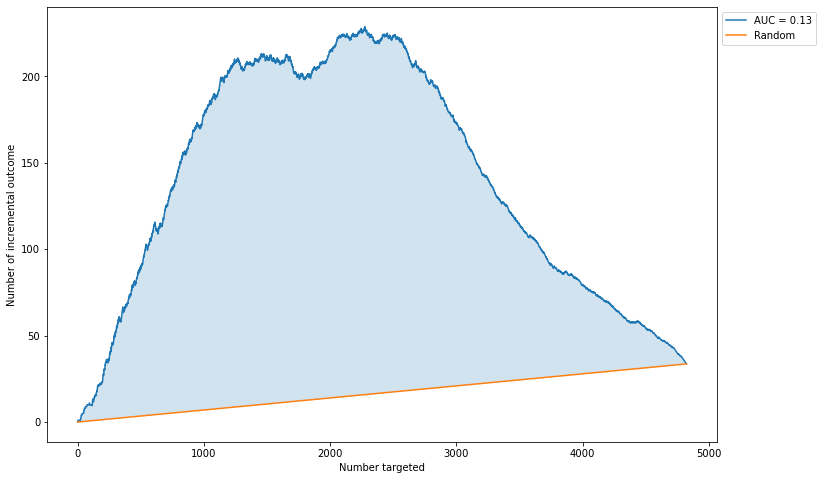

In [162]:
###get propensity score for features to get AUC curve.###
## xgboost + random forest  + neural net and check. 
## get higher metric ###
# class transformation
print("Class Transformation model:")

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, pred_uplift_ct, trmnt_val) 
print(f"Qini coefficient: {auqc:.3f}")

auuc = uplift_auc_score(y_val, pred_uplift_ct, trmnt_val) 
print(f"Uplift auc score: {auuc:.3f}")

# qini curve
plot_qini_curve(y_val, pred_uplift_ct, trmnt_val, perfect=False);
fig = plt.gcf()
fig.set_size_inches(12, 8)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



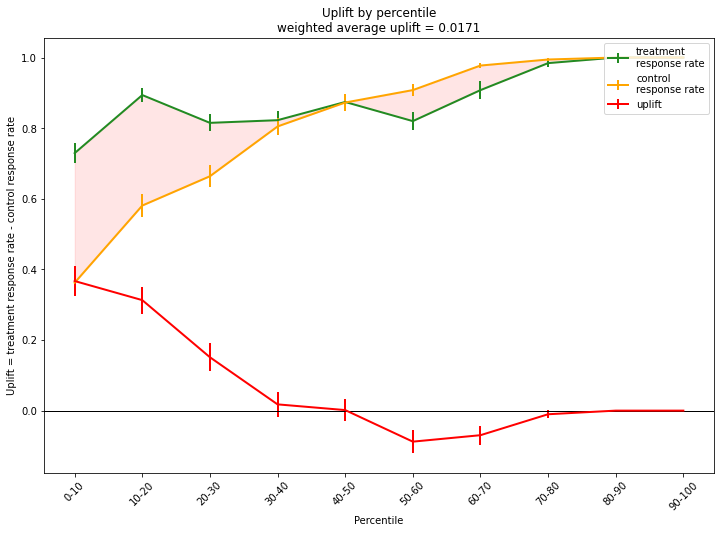

In [163]:
plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

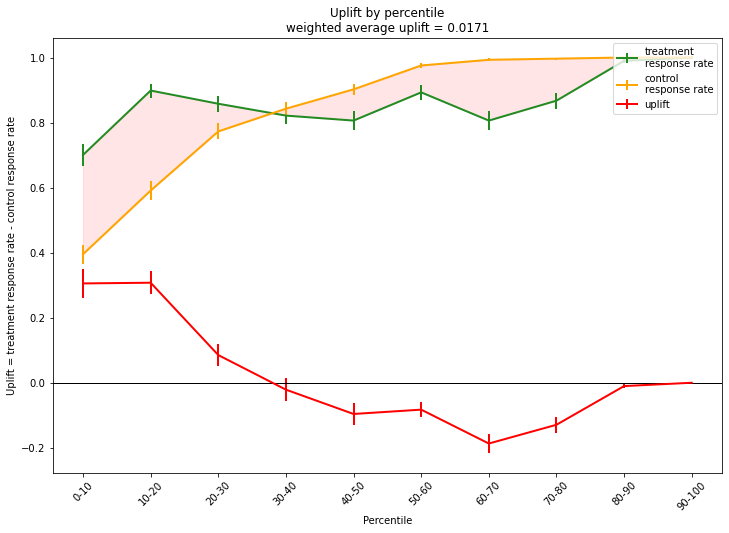

In [164]:
plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="by_group", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

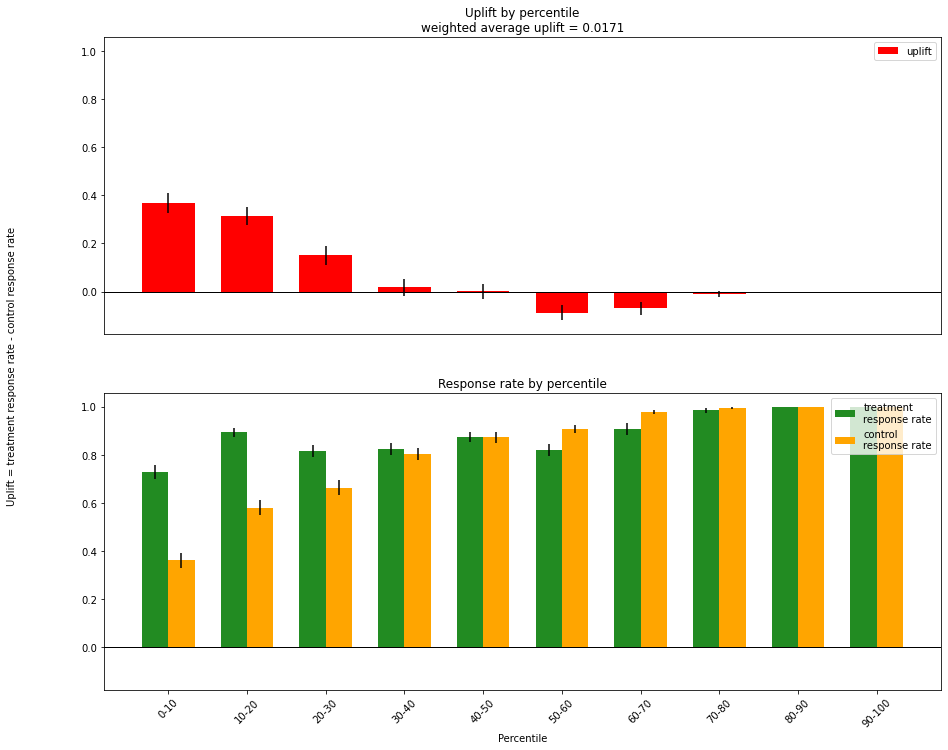

In [166]:

plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)


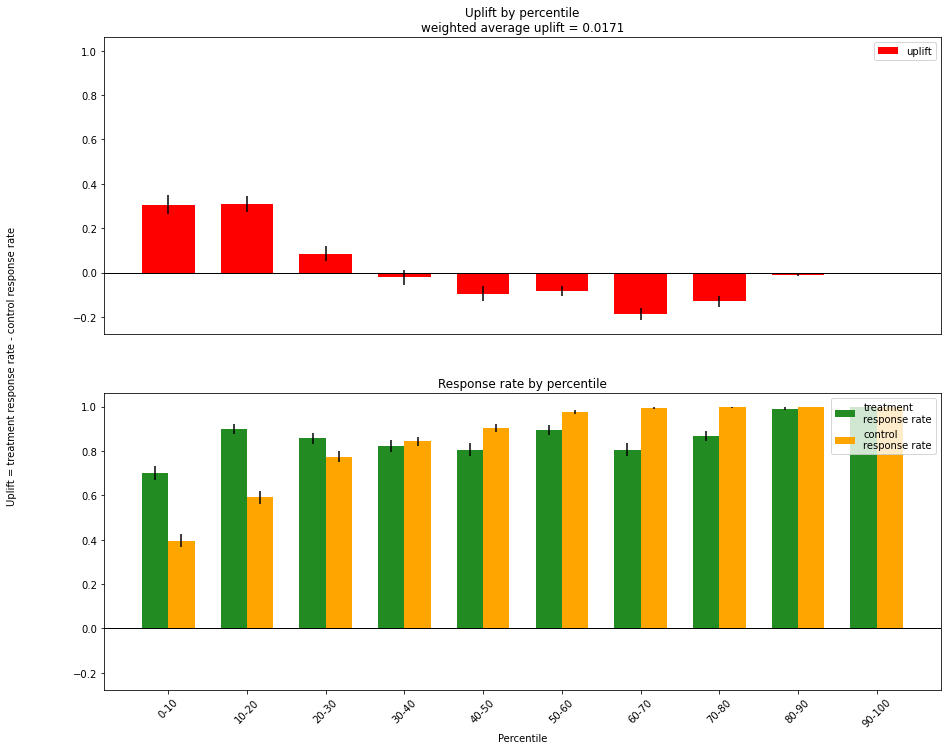

In [167]:

plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="by_group", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)



In [ ]:
X_val.loc[:, 'pred'] = model_ct.predict(X_val.values)


NameError: name 'X_val' is not defined

In [ ]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score


In [ ]:
plot_qini_curve(y_val, pred_uplift_ct, trmnt_val, perfect=True);

In [ ]:
sklift.viz.base.plot_treatment_balance_curve(pred_uplift_ct, trmnt_val, random=True, winsize=0.1)


In [113]:
# # model results: conditional probabilities of treatment effect
# # probability of performing the targeted action (visits):
# prob_treat = model_sm.trmnt_preds_         # probability in treatment group
# prob_control = model_sm.ctrl_preds_        # probability in control group
# plot_uplift_preds(trmnt_preds=prob_treat, ctrl_preds=prob_control);

In [107]:
# # uplift by customer
# dfZ = pd.DataFrame()
# dfZ["prob_treat"] = model_sm.trmnt_preds_   
# dfZ["prob_control"] = model_sm.ctrl_preds_   
# dfZ["uplift"] = pred_uplift_sm
# dfZ.sort_values("uplift", inplace=True, ascending=False)   

# # classify customers by their response probabilities
# cutbins = [-1, -0.01, 0.01, 1]
# cutlabels = ["sleeping dog", "sure thing", "persuadable"]
# dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)


# # sure things needs to be split between lost causes and real sure things
# dfZ["cats"] = dfZ["cats"].cat.add_categories(["lost cause"])
# dfZ.loc[(dfZ["cats"] == "sure thing") & (dfZ["prob_control"] < 0.20), "cats"] = "lost cause"
# dfZ.sort_values("uplift", ascending=False)

,prob_treat,prob_control,uplift,cats
4054,0.230,0.210,0.020,persuadable
3416,0.706,0.694,0.012,persuadable
4072,0.706,0.694,0.012,persuadable
4501,0.604,0.592,0.011,persuadable
1588,0.604,0.592,0.011,persuadable
...,...,...,...,...
1513,0.727,0.740,-0.013,sleeping dog
351,0.727,0.740,-0.013,sleeping dog
1878,0.735,0.748,-0.013,sleeping dog
97,0.735,0.748,-0.013,sleeping dog


In [100]:
# # uplift by customer category
# pd.pivot_table(dfZ, index = "cats", values = ["prob_control", "prob_treat", "uplift"], aggfunc="median")


,prob_control,prob_treat,uplift
cats,,,
sleeping dog,0.740,0.727,-0.013
sure thing,0.998,0.998,-0.000
persuadable,0.694,0.705,0.011
lost cause,0.001,0.001,0.000


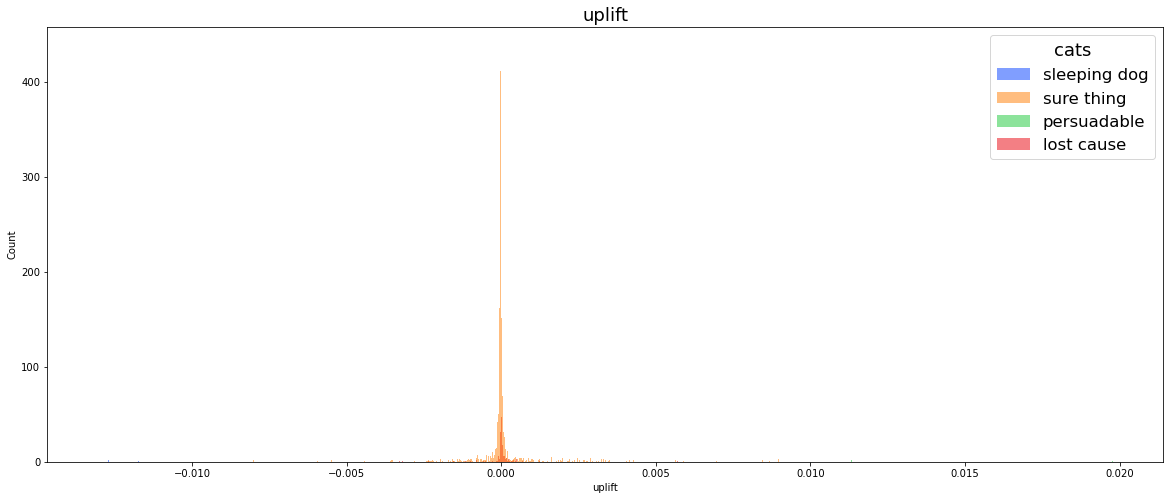

In [101]:
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(20, 8))
# with sns.plotting_context("notebook", font_scale=1.5):
#     sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
#     ax.set_xlim(-0.002,0.002)
#     ax.set_title('uplift');

In [102]:
# # classify customers by their response probabilities
# cutbins = [-1, -0.01, 0.01, 0.08, 1]
# cutlabels = ["sleeping dog", "sure thing", "persuadable", "avid persuadables"]
# dfZ["cats"] = pd.cut(dfZ["uplift"], bins=cutbins, labels=cutlabels)

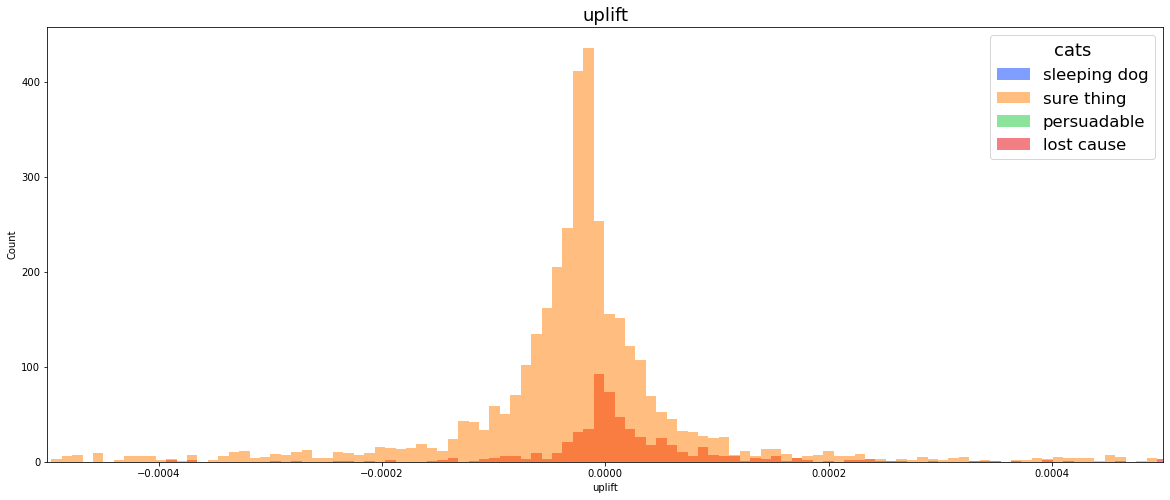

In [109]:
# import seaborn as sns
# fig, ax = plt.subplots(figsize=(20, 8))
# with sns.plotting_context("notebook", font_scale=1.5):
#     sns.histplot(data=dfZ, x='uplift', hue='cats', stat='count', edgecolor=None, palette="bright")
#     ax.set_xlim(-0.0005,0.0005)
#     ax.set_title('uplift');

In [104]:
# dfZ

,prob_treat,prob_control,uplift,cats
4054,0.230,0.210,0.020,persuadable
4072,0.706,0.694,0.012,persuadable
3416,0.706,0.694,0.012,persuadable
4501,0.604,0.592,0.011,persuadable
1588,0.604,0.592,0.011,persuadable
...,...,...,...,...
1513,0.727,0.740,-0.013,sleeping dog
351,0.727,0.740,-0.013,sleeping dog
1878,0.735,0.748,-0.013,sleeping dog
97,0.735,0.748,-0.013,sleeping dog


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



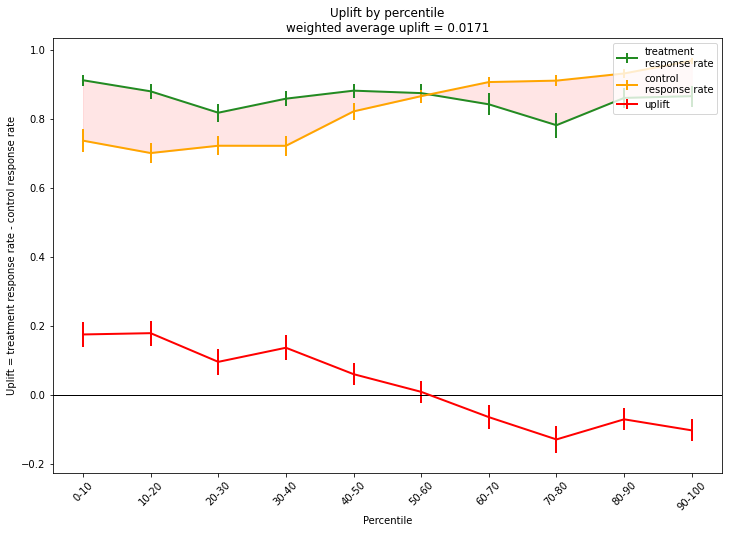

In [64]:
plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="overall", kind="line");
fig = plt.gcf()
fig.set_size_inches(12, 8)

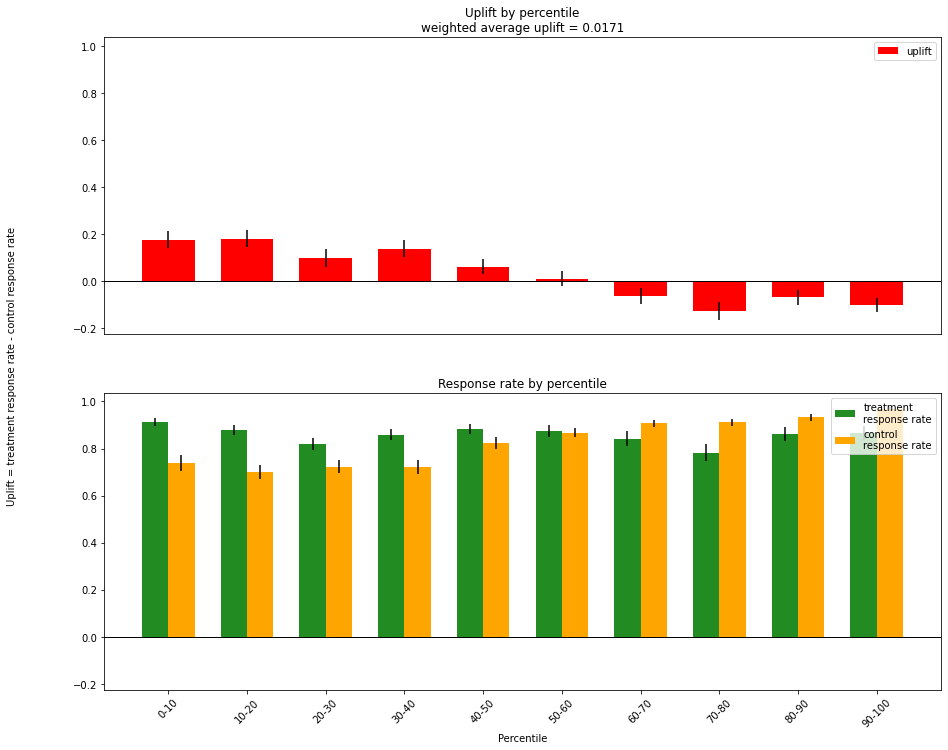

In [57]:
plot_uplift_by_percentile(y_val, pred_uplift_ct, trmnt_val, strategy="overall", kind="bar");
fig = plt.gcf()
fig.set_size_inches(15, 12)

In [67]:
model_ct.estimator.get_feature_importance(prettified=True).head(10)


,Feature Id,Importances
0,ZIP_POSTAL_CODE,14.734
1,USER_HOUR_OF_WEEK,11.132
2,DEVICE_MODEL,8.901
3,SITE,8.456
4,METRO,7.704
5,SUPPLY_VENDOR,6.691
6,DEVICE_MAKE,5.219
7,REGION,4.818
8,DEVICE_NAME,3.933
9,AD_SIZE,3.484


-0.21584162500487092